In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import source.selection_criteria as sc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
from scipy.interpolate import interp1d
from astroML.lumfunc import bootstrap_Cminus

/Users/runburg/github/agn_lf


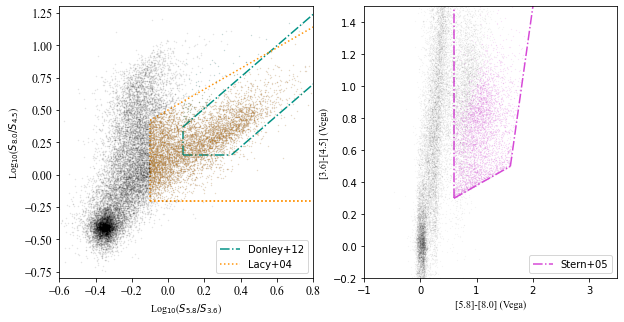

In [2]:
xmmlss = fits.open('./data/master_cat_irac3_mips24', memmap=True)
catalog = table.Table.read('./data/master_cat_irac3_mips24')
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
fig, axs = sc.plot_wedge(catalog[never_nan], flux36, flux45, flux58, flux80, selection=['lacy05', 'stern05', 'donley12'])
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]

In [3]:
xmmlss[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  612 / width of table in bytes                        
NAXIS2  =                30271 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   77 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'help_id_1'          / label for column 1                             
TFORM1  = '27A     '           / format for column 1                            
TTYPE2  = 'field   '           / label for column 2                             
TFORM2  = '18A     '        

In [4]:
mi1 = 'm_irac_i1'
mi2 = 'm_irac_i2'
m_58 = 'm_irac_i3'

In [16]:
cosmo = af.setup_cosmology()
print('selected_agn:', len(ct_lacy))

ct_lacy = ct_lacy[(ct_lacy['z1_median'] > 0 ) | (ct_lacy['zspec'] > 0)]
# ct_lacy = ct_lacy[ct_lacy['z_eazy'] > 0]
print('selected agn with z:', len(ct_lacy))

# unit conversion: ujansky -> jansky: 1e-6
# jansky -> erg / s / cm**2 / Hz: 1e-23
# erg / s / Hz -> erg / s: nu = c/lambda = 3e8 / 3.6e-6
# unit_conversion = 1e-6 * 1e-23 * 3e8 / 3.6e-6 * (3.086e24)**2
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

unbias_photoz = 0.0
z = np.array([row['zspec'] if row['zspec'] > 0 else row['z1_median'] - unbias_photoz for row in ct_lacy])
z[z <= 0] = 0

m = ct_lacy[m_58]
# 
# spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)
# spectral_index[spectral_index < -4] = -2
# spectral_index = np.array([0])

selected_agn: 5914
selected agn with z: 5914


In [17]:
m

18.955919586884995
19.06312281334106
19.735109926365105
19.866981619740592
18.95649129781642
18.313137498429874
18.289926027424947
19.77861211084332
19.28122258699188
18.390175156888425
19.29191805475498


In [18]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46
num_bins_z = 10
num_bins_l = 15

# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max)+0.01, num=num_bins_z)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

def l_to_m(Ls):
    return 4.77 - 2.5 * np.log10(Ls / 3.9e33)

m_bins = l_to_m(l_bins)

good_redshift_and_l_selected = (z_sample_min < z) & (z_sample_max > z) #& (m > m_bins[0]) & (m < m_bins[-1])
z = z[good_redshift_and_l_selected]
m = m[good_redshift_and_l_selected]

z_sample = np.linspace(z_bins[0], z_bins[-1], 500)
mu_sample = cosmo.distmod(z_sample).value
mu_z = interp1d(z_sample, mu_sample)
z_mu = interp1d(mu_sample, z_sample)

# m_max = l_to_m(4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2))
m_max = 22

In [23]:
m_bins

array([-17.44514162, -18.15942733, -18.87371305, -19.58799876,
       -20.30228448, -21.01657019, -21.7308559 , -22.44514162,
       -23.15942733, -23.87371305, -24.58799876, -25.30228448,
       -26.01657019, -26.7308559 , -27.44514162])

In [33]:
import os
def compute_luminosity_function(z, m, M, m_max, zmax, Mbins, zbins, archive_file):
    """Compute the luminosity function and archive in the given file.

    If the file exists, then the saved results are returned.
    """
    Mmax = m_max - (m - M)
    z_max = [zmax] * len(Mmax)

    if not os.path.exists(archive_file):
        print("- computing bootstrapped luminosity function ",
              "for {0} points".format(len(z)))

        dist_z, err_z, dist_M, err_M = bootstrap_Cminus(z, M, z_max, Mmax,
                                                        zbins, Mbins,
                                                        Nbootstraps=20,
                                                        normalize=True)
        np.savez(archive_file,
                 zbins=zbins, dist_z=dist_z, err_z=err_z,
                 Mbins=Mbins, dist_M=dist_M, err_M=err_M)
    else:
        print("- using precomputed bootstrapped luminosity function results")
        archive = np.load(archive_file)
        zbins = archive['zbins']
        dist_z = archive['dist_z']
        err_z = archive['err_z']
        Mbins = archive['Mbins']
        dist_M = archive['dist_M']
        err_M = archive['err_M']

    return zbins, dist_z, err_z, Mbins, dist_M, err_M


In [34]:
lf_vals = np.zeros((num_bins_z-1, num_bins_l-1))
lf_errs = np.zeros((num_bins_z-1, num_bins_l-1))

for i in range(num_bins_z-1):
    inbin = (z > z_bins[i]) & (z < z_bins[i+1])
    ms = m[inbin].data
    zs = z[inbin].data
    Ms = ms - mu_z(zs)
    zbins = np.linspace(z_bins[i], z_bins[i+1], num=20)
        
    _, dist_z, err_z, _, dist_M, err_M = compute_luminosity_function(zs, ms, Ms, m_max, z_bins[i+1], m_bins, zbins, "hi")
        
    lf_vals[i] = dist_M
    lf_errs[i] = err_M

- computing bootstrapped luminosity function  for 754 points
- computing bootstrapped luminosity function  for 572 points
- computing bootstrapped luminosity function  for 595 points
- computing bootstrapped luminosity function  for 623 points
- computing bootstrapped luminosity function  for 613 points
- computing bootstrapped luminosity function  for 750 points
- computing bootstrapped luminosity function  for 330 points
- computing bootstrapped luminosity function  for 136 points
- computing bootstrapped luminosity function  for 32 points


In [35]:
lf_vals

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0675166 , 0.35845848, 0.55782352, 0.29567399,
        0.07612741, 0.03722989, 0.00276306, 0.00255028],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00550544, 0.04657621, 0.3860727 , 0.5535751 ,
        0.27078337, 0.09050914, 0.03191961, 0.00685725],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00151151, 0.10377124, 0.50640719,
        0.46032295, 0.21190986, 0.08008252, 0.02422537],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00899431, 0.21078374,
        0.5120131 , 0.39219581, 0.18134631, 0.06979609],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01515   ,
        0.26392207, 0.50910635, 0.40102909, 0.13935938],
       [0.        , 0.        , 0. 

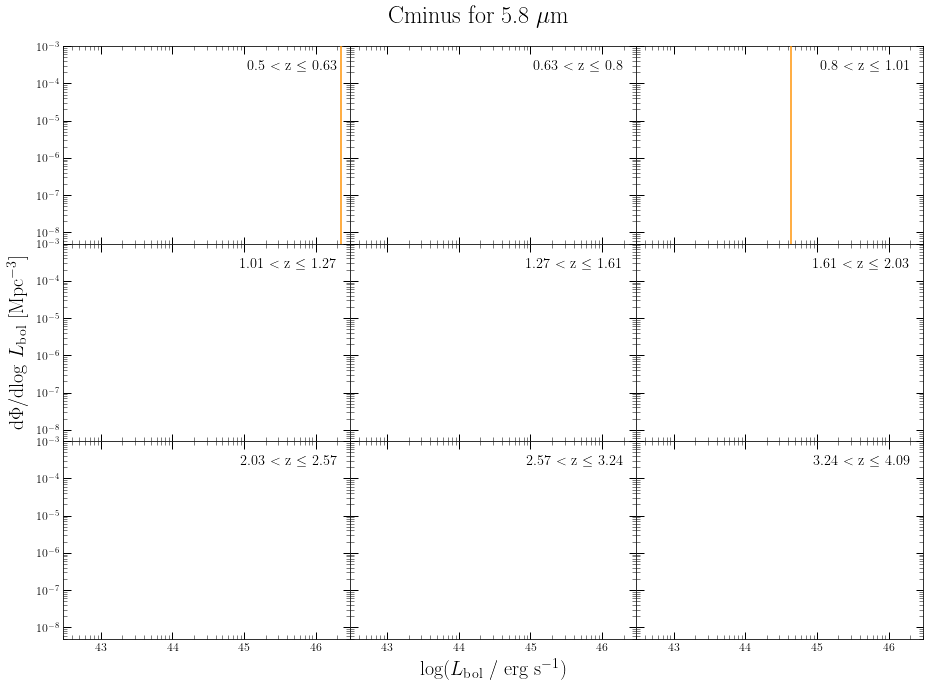

In [36]:
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, \
                                     title=r'Cminus for 5.8 $\mu$m', \
                                     outfile='./output/ir_lf_cminus.png', lum_sublabel=r'_{{\mathrm{bol}}}')

In [ ]:
#------------------------------------------------------------
# Perform the computation and plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.13, right=0.95, wspace=0.3,
                    bottom=0.08, top=0.95, hspace=0.2)

for i in range(2):
    m = data[i]['petroMag_r']
    z = data[i]['z']
    M = m - mu_z(z)

    # compute the luminosity function for the given subsample
    zbins, dist_z, err_z, Mbins, dist_M, err_M = \
        compute_luminosity_function(z, m, M, m_max, archive_files[i])

    #------------------------------------------------------------
    # First axes: plot the observed 2D distribution of (z, M)
    ax = fig.add_subplot(2, 2, 1 + 2 * i)
    H, xbins, ybins = np.histogram2d(z, M, bins=(np.linspace(0.08, 0.12, 31),
                                                 np.linspace(-23, -20, 41)))
    ax.imshow(H.T, origin='lower', aspect='auto',
              interpolation='nearest', cmap=plt.cm.binary,
              extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))

    # plot the cutoff curve
    zrange = np.linspace(0.07, 0.13, 100)
    Mmax = m_max - mu_z(zrange)
    ax.plot(zrange, Mmax, '-k')

    ax.text(0.95, 0.95, titles[i] + "\n$N = %i$" % len(z),
            ha='right', va='top',
            transform=ax.transAxes)

    ax.set_xlim(0.075, 0.125)
    ax.set_ylim(-22, -19.8)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$M$')

    #------------------------------------------------------------
    # Second axes: plot the inferred 1D distribution in z
    ax2 = fig.add_subplot(2, 2, 2)
    factor = 0.08 ** 2 / (0.5 * (zbins[1:] + zbins[:-1])) ** 2
    ax2.errorbar(0.5 * (zbins[1:] + zbins[:-1]),
                 factor * dist_z, factor * err_z,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

    #------------------------------------------------------------
    # Third axes: plot the inferred 1D distribution in M
    ax3 = fig.add_subplot(224, yscale='log')

    # truncate the bins so the plot looks better
    Mbins = Mbins[3:-1]
    dist_M = dist_M[3:-1]
    err_M = err_M[3:-1]

    ax3.errorbar(0.5 * (Mbins[1:] + Mbins[:-1]), dist_M, err_M,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

#------------------------------------------------------------
# set labels and limits
ax2.legend(loc=1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\rho(z) / [z / 0.08]^2$')
ax2.set_xlim(0.075, 0.125)
ax2.set_ylim(10, 25)

ax3.legend(loc=3)
ax3.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax3.set_xlabel(r'$M$')
ax3.set_ylabel(r'$\Phi(M)$')
ax3.set_xlim(-20, -23.5)
ax3.set_ylim(1E-5, 2)

plt.show()

In [ ]:
z_min = 0.08
z_max = 0.12
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > z_min]
data = data[data['z'] < z_max]
data = data[data['petroMag_r'] < m_max]

# divide red sample and blue sample based on u-r color
ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

# truncate sample (optional: speeds up computation)
#data_red = data_red[::10]
#data_blue = data_blue[::10]
print(data_red.size, "red galaxies")
print(data_blue.size, "blue galaxies")

#------------------------------------------------------------
# Distance Modulus calculation:
#  We need functions approximating mu(z) and z(mu)
#  where z is redshift and mu is distance modulus.
#  We'll accomplish this using the cosmology class and
#  scipy's cubic spline interpolation.
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=0)
z_sample = np.linspace(0.01, 1.5, 100)
mu_sample = cosmo.distmod(z_sample).value
mu_z = interpolate.interp1d(z_sample, mu_sample)
z_mu = interpolate.interp1d(mu_sample, z_sample)

data = [data_red, data_blue]
titles = ['$u-r > 2.22$', '$u-r < 2.22$']
markers = ['o', '^']
archive_files = ['lumfunc_red.npz', 'lumfunc_blue.npz']


def compute_luminosity_function(z, m, M, m_max, archive_file):
    """Compute the luminosity function and archive in the given file.

    If the file exists, then the saved results are returned.
    """
    Mmax = m_max - (m - M)
    zmax = z_mu(m_max - M)

    if not os.path.exists(archive_file):
        print("- computing bootstrapped luminosity function ",
              "for {0} points".format(len(z)))

        zbins = np.linspace(0.08, 0.12, 21)
        Mbins = np.linspace(-24, -20.2, 21)
        dist_z, err_z, dist_M, err_M = bootstrap_Cminus(z, M, zmax, Mmax,
                                                        zbins, Mbins,
                                                        Nbootstraps=20,
                                                        normalize=True)
        np.savez(archive_file,
                 zbins=zbins, dist_z=dist_z, err_z=err_z,
                 Mbins=Mbins, dist_M=dist_M, err_M=err_M)
    else:
        print("- using precomputed bootstrapped luminosity function results")
        archive = np.load(archive_file)
        zbins = archive['zbins']
        dist_z = archive['dist_z']
        err_z = archive['err_z']
        Mbins = archive['Mbins']
        dist_M = archive['dist_M']
        err_M = archive['err_M']

    return zbins, dist_z, err_z, Mbins, dist_M, err_M


#------------------------------------------------------------
# Perform the computation and plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.13, right=0.95, wspace=0.3,
                    bottom=0.08, top=0.95, hspace=0.2)

for i in range(2):
    m = data[i]['petroMag_r']
    z = data[i]['z']
    M = m - mu_z(z)

    # compute the luminosity function for the given subsample
    zbins, dist_z, err_z, Mbins, dist_M, err_M = \
        compute_luminosity_function(z, m, M, m_max, archive_files[i])

    #------------------------------------------------------------
    # First axes: plot the observed 2D distribution of (z, M)
    ax = fig.add_subplot(2, 2, 1 + 2 * i)
    H, xbins, ybins = np.histogram2d(z, M, bins=(np.linspace(0.08, 0.12, 31),
                                                 np.linspace(-23, -20, 41)))
    ax.imshow(H.T, origin='lower', aspect='auto',
              interpolation='nearest', cmap=plt.cm.binary,
              extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))

    # plot the cutoff curve
    zrange = np.linspace(0.07, 0.13, 100)
    Mmax = m_max - mu_z(zrange)
    ax.plot(zrange, Mmax, '-k')

    ax.text(0.95, 0.95, titles[i] + "\n$N = %i$" % len(z),
            ha='right', va='top',
            transform=ax.transAxes)

    ax.set_xlim(0.075, 0.125)
    ax.set_ylim(-22, -19.8)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$M$')

    #------------------------------------------------------------
    # Second axes: plot the inferred 1D distribution in z
    ax2 = fig.add_subplot(2, 2, 2)
    factor = 0.08 ** 2 / (0.5 * (zbins[1:] + zbins[:-1])) ** 2
    ax2.errorbar(0.5 * (zbins[1:] + zbins[:-1]),
                 factor * dist_z, factor * err_z,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

    #------------------------------------------------------------
    # Third axes: plot the inferred 1D distribution in M
    ax3 = fig.add_subplot(224, yscale='log')

    # truncate the bins so the plot looks better
    Mbins = Mbins[3:-1]
    dist_M = dist_M[3:-1]
    err_M = err_M[3:-1]

    ax3.errorbar(0.5 * (Mbins[1:] + Mbins[:-1]), dist_M, err_M,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

#------------------------------------------------------------
# set labels and limits
ax2.legend(loc=1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\rho(z) / [z / 0.08]^2$')
ax2.set_xlim(0.075, 0.125)
ax2.set_ylim(10, 25)

ax3.legend(loc=3)
ax3.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax3.set_xlabel(r'$M$')
ax3.set_ylabel(r'$\Phi(M)$')
ax3.set_xlim(-20, -23.5)
ax3.set_ylim(1E-5, 2)

plt.show()